In [1]:
import sys
sys.path.append('../') 

import MetaTrader5 as mt5
import pytz
import numpy as np
import pandas_ta as ta
import vectorbt as vbt
import pandas as pd

from datetime import datetime
from terminal.Extensions.Mt5Helper import Mt5Helper
from terminal.Extensions.Range import Range

In [2]:
mt5.initialize()

True

In [3]:
slippage = 5
brick_size = 25

from_date = datetime(2024, 6, 3, tzinfo=pytz.utc)
to_date = datetime(from_date.year, 6, 3, 23, 59, 59, 0, tzinfo=pytz.utc)
data = mt5.copy_ticks_range('WIN$', from_date, to_date, mt5.COPY_TICKS_TRADE)

rates = Mt5Helper.OHLC(data, '10s')
rates.index = rates.index.tz_localize(None)

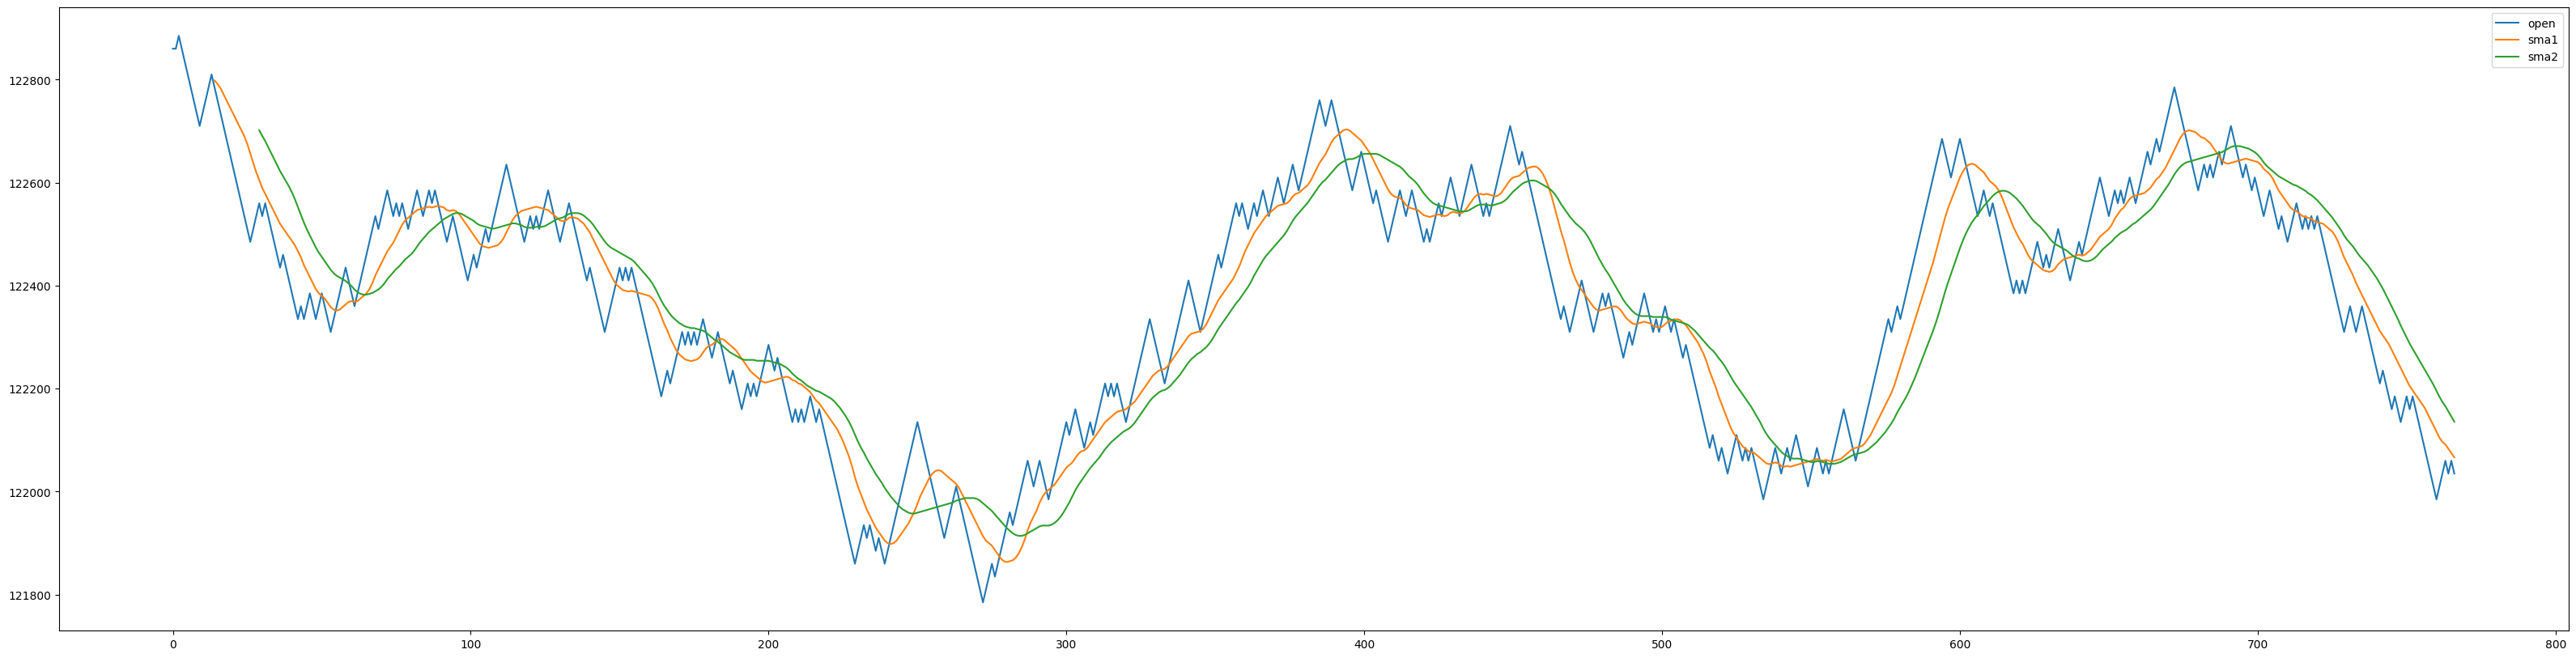

In [6]:
range = Range(brick_size=brick_size, data=rates["open"])
range_oc = pd.DataFrame(range.bricks)
range_oc["sma1"] = range_oc["open"].rolling(15).mean()
range_oc["sma2"] = range_oc["open"].rolling(30).mean()
range_oc[["open", "sma1", "sma2"]].plot(figsize=(40,10))
range_oc.to_excel("output.xlsx")

In [7]:

# Create the "Golden Cross" 
range_oc["GC"] = range_oc["sma1"] > range_oc["sma2"]

# Create boolean Signals(TS_Entries, TS_Exits) for vectorbt
golden = range_oc.ta.tsignals(range_oc.GC, asbool=True, append=True)

# Sanity Check (Ensure data exists)
print(range_oc)

# Create the Signals Portfolio
pf = vbt.Portfolio.from_signals(range_oc.close, entries=golden.TS_Entries, exits=golden.TS_Exits, freq="D", init_cash=100_000, fees=0.0025, slippage=0.0025)

# Print Portfolio Stats and Return Stats
print(pf.stats())
print(pf.returns_stats())

      type      open     close           sma1           sma2     GC  \
0    first  122860.0  122860.0            NaN            NaN  False   
1       up  122860.0  122885.0            NaN            NaN  False   
2     down  122885.0  122860.0            NaN            NaN  False   
3     down  122860.0  122835.0            NaN            NaN  False   
4     down  122835.0  122810.0            NaN            NaN  False   
..     ...       ...       ...            ...            ...    ...   
762     up  122035.0  122060.0  122096.666667  122174.166667  False   
763   down  122060.0  122035.0  122091.666667  122165.833333  False   
764     up  122035.0  122060.0  122083.333333  122155.833333  False   
765   down  122060.0  122035.0  122075.000000  122145.833333  False   
766   down  122035.0  122010.0  122066.666667  122135.833333  False   

     TS_Trends  TS_Trades  TS_Entries  TS_Exits  
0        False          0       False     False  
1        False          0       False     False

<Axes: xlabel='time_msc'>

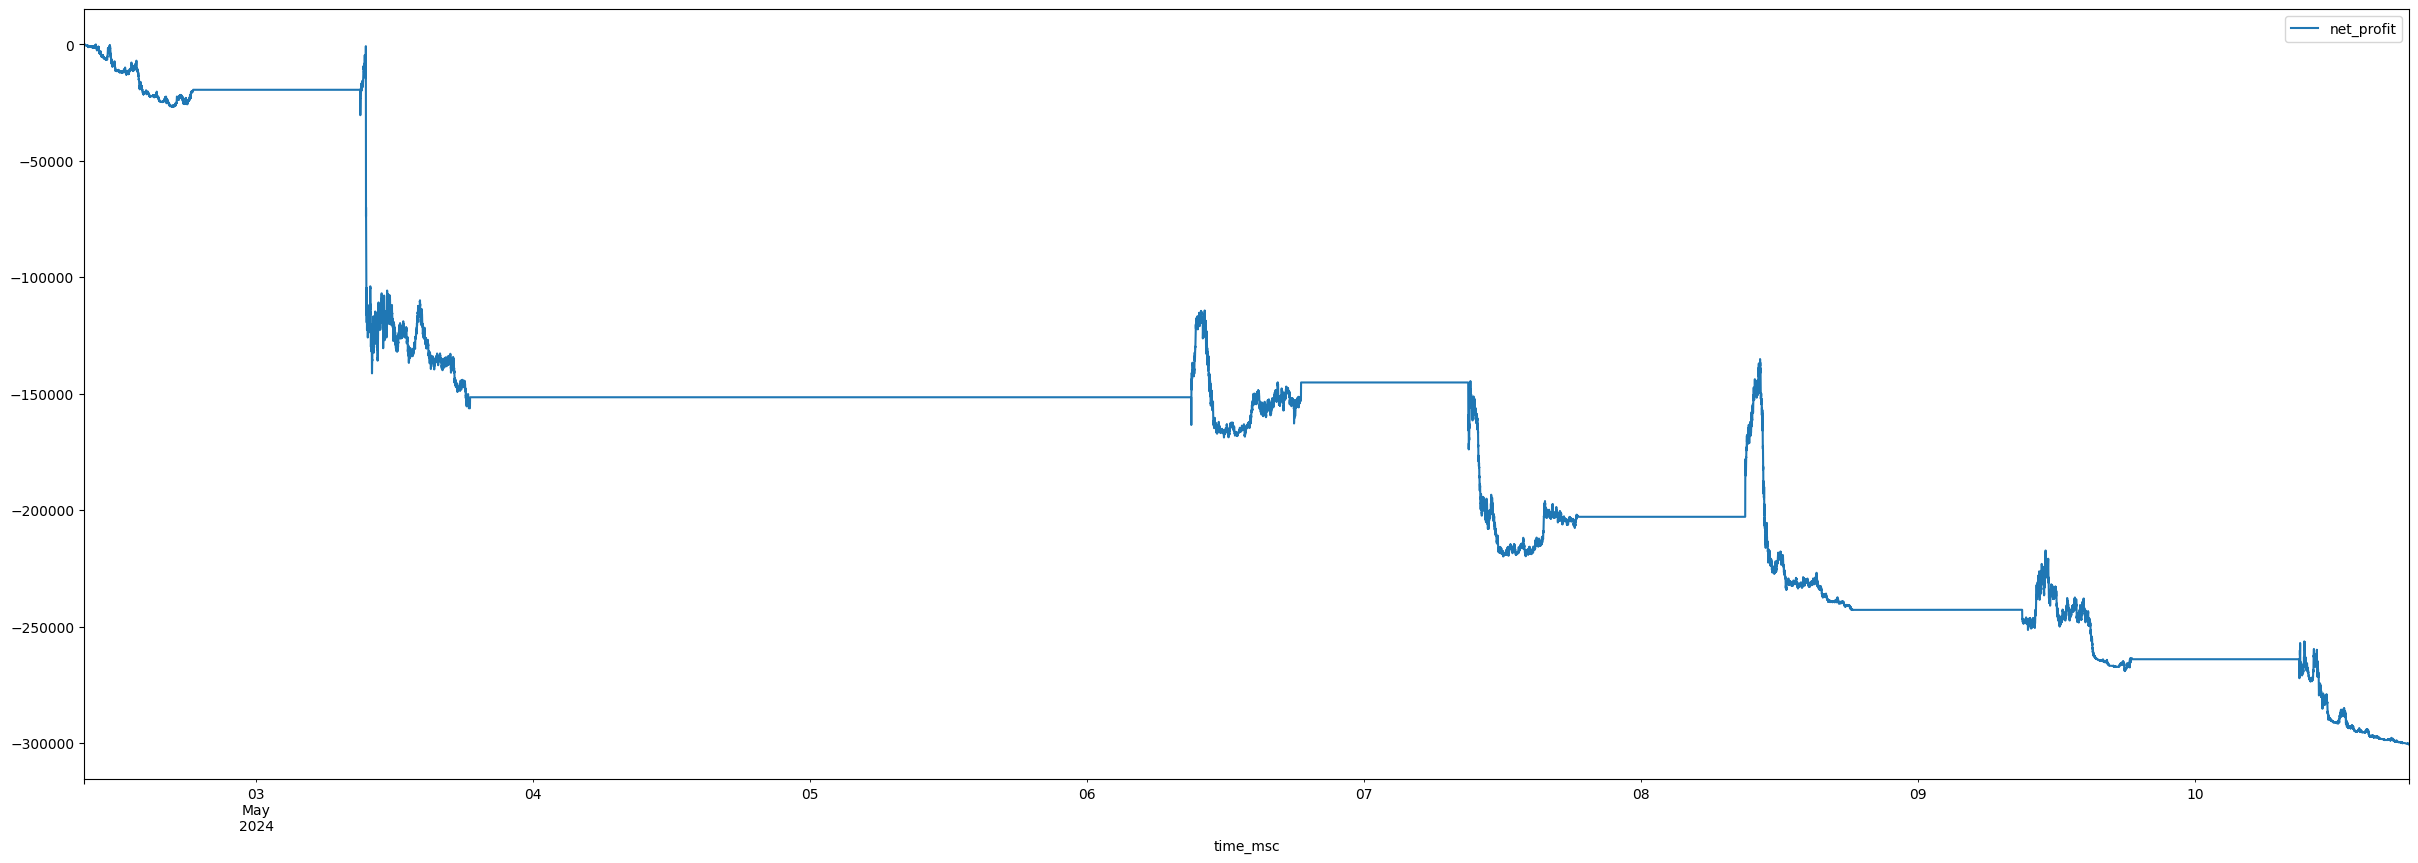

In [27]:
sum_buy = 0
buy_qty = 0
buy_avg = 0
buy_profit = 0

sum_sell = 0
sell_qty = 0
sell_avg = 0
sell_profit = 0

net_qty = 0
net_profit = 0

used_slippage = 0


def update(i):
    rates.loc[i, "sum_buy"] = sum_buy
    rates.loc[i, "buy_qty"] = buy_qty
    rates.loc[i, "buy_avg"] = buy_avg
    rates.loc[i, "buy_profit"] = buy_profit
    rates.loc[i, "sum_sell"] = sum_sell
    rates.loc[i, "sell_qty"] = sell_qty
    rates.loc[i, "sell_avg"] = sell_avg
    rates.loc[i, "sell_profit"] = sell_profit
    rates.loc[i, "net_qty"] = net_qty
    rates.loc[i, "net_profit"] = net_profit
    rates.loc[i, "slippage"] = used_slippage


range = None
last_open = 0

for i, item in rates.iterrows():
    if np.isnan(item.open):
        update(i)
        continue

    used_slippage = slippage

    if range is None:
        range = Range(brick_size=brick_size, data=rates.loc[:i].iloc[-1:]["open"])
    else:
        range.check_new_price(item["open"])

    range_oc = pd.DataFrame(range.bricks)
    
    range_oc["sma"] = range_oc["close"].rolling(10).mean()
    
    if range_oc.count()["open"] <= 1:
        update(i)
        continue

    if last_open != range_oc.iloc[-1]["open"]:
        if range_oc.iloc[-1]["close"] > range_oc.iloc[-1]["sma"]:
            qty = 1
            sum_buy += qty * (item.open + used_slippage)
            buy_qty += qty

        if range_oc.iloc[-1]["close"] < range_oc.iloc[-1]["sma"]:
            qty = 1
            sum_sell += qty * (item.open - used_slippage)
            sell_qty += qty

    last_open = range_oc.iloc[-1]["open"]

    buy_avg = 0 if sum_buy == 0 else sum_buy / buy_qty
    sell_avg = 0 if sum_sell == 0 else sum_sell / sell_qty

    buy_profit = 0 if buy_qty == 0 else (item.open - used_slippage - buy_avg) * buy_qty
    sell_profit = 0 if sell_qty == 0 else (sell_avg - item.open + used_slippage) * sell_qty

    net_qty = buy_qty - sell_qty
    net_profit = buy_profit + sell_profit

    update(i)


rates.iloc[:][["net_profit"]].plot(figsize=(30, 10))

In [28]:
rates.to_excel("output_result.xlsx")